# Google Play Store Apps EDA

Here [Google Play Store Apps](https://www.kaggle.com/lava18/google-play-store-apps) by [@Lavanya](https://www.kaggle.com/lava18) from [Kaggle](https://www.kaggle.com/) is used.

The data source contains 2 CSV files namely `googleplaystore.csv` and `googleplaystore`.

- **googleplaystore.csv** - It has details of the applications on Google Play. There are 13 features which describes a given sample.
- **googleplaystore_user_reviews.csv** - This file contains the first `most relevant` 100 reviews for each app. Each review text/comment has been pre-processed and attributed with 3 new features - Sentiment, Sentiment Polarity and Sentiment Subjectivity.

For this project only `googleplaystore.csv` data is used.

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import spacy
from scipy.stats import zscore

In [2]:
df = pd.read_csv('../data/googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Cleaning

Data description

- **App** - Application name
- **Category** - Category the app belongs to
- **Rating** - Overall user rating of the app (as when scraped)
- **Reviews** - Number of user reviews for the app (as when scraped)
- **Size** - Size of the app (as when scraped)
- **Installs** - Number of user downloads/installs for the app (as when scraped)
- **Type** - Paid or Free
- **Price** - Price of the app (as when scraped)
- **Content Rating** - Age group the app is targeted at - Children / Mature 21+ / Adult
- **Genres** - An app can belong to multiple genres (apart from its main category). For eg, a musical family game will belong to Music, Game, Family genres.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


There's only one numeric column in the data set i.e. `Rating`. Analyzing descriptive statistics for `Rating` column tells that there are some **outliers** since the standard deviation is 0.53 and mean is 4.19 while the max is 19 and min is 1.

Let's look at samples having rating more than 5 (choosing 5 since an app in google play store is usually rated between 0 to 5)

In [5]:
df.loc[df.Rating > 5]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


There's only one sample where the rating is above 5. It looks like the values from `Rating` column is been shifted to the left spanning 1 column. This means that the app doesn't have a category. 

Looking at google play store for the app, the app has `Lifestyle` as its category, so updating the sample.

In [6]:
# Checking if `Lifestyle` category exists in the data set
list(filter(lambda category: category == 'LIFESTYLE', df.Category.unique()))

['LIFESTYLE']

Yes, it does exists. Updating the sample values.

In [7]:
idx = 10472

df.at[idx, 'Category'] = 'LIFESTYLE'
df.at[idx, 'Rating'] = 1.9
df.at[idx, 'Reviews'] = 19
df.at[idx, 'Size'] = '3.0M'
df.at[idx, 'Installs'] = '1,000+'
df.at[idx, 'Type'] = 'Free'
df.at[idx, 'Price'] = 0
df.at[idx, 'Content Rating'] = 'Everyone'
df.at[idx, 'Genres'] = np.nan
df.at[idx, 'Last Updated'] = 'February 11, 2018'
df.at[idx, 'Current Ver'] = '1.0.19'
df.at[idx, 'Android Ver'] = '4.0 and up'

df.loc[idx]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                        LIFESTYLE
Rating                                                1.9
Reviews                                                19
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                            February 11, 2018
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [8]:
# Get info about missing data in a pd.DataFrame
# Total number of missing and its percentage w.r.t. the size of the dataset
def missing_data_info(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis='columns', keys=['Total', 'Percent'])

In [9]:
missing_data_info(df)

,Total,Percent
Rating,1474,0.135965
Current Ver,8,0.000738
Android Ver,2,0.000184
Type,1,0.000092
Genres,1,0.000092
App,0,0.000000
Category,0,0.000000
Reviews,0,0.000000
Size,0,0.000000
Installs,0,0.000000


Dropping columns where percentage of missing data is very low.

In [10]:
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [11]:
info_df = missing_data_info(df)
for column_name, (_, percent) in info_df.iterrows():
    if percent < 0.01 and percent != 0:
        drop_index = df.loc[pd.isnull(df[column_name])].index
        df.drop(drop_index, axis='index', inplace=True)

missing_data_info(df)

,Total,Percent
Rating,1469,0.135654
App,0,0.000000
Category,0,0.000000
Reviews,0,0.000000
Size,0,0.000000
Installs,0,0.000000
Type,0,0.000000
Price,0,0.000000
Content Rating,0,0.000000
Genres,0,0.000000


For now, except for `Rating` column there aren't any null values in any other column (there can be missing data in those columns in some other form).

In [12]:
df['Rating']

0        4.1
1        3.9
2        4.7
3        4.5
4        4.3
        ... 
10836    4.5
10837    5.0
10838    NaN
10839    4.5
10840    4.5
Name: Rating, Length: 10829, dtype: float64

In [13]:
df['Rating'].max()

5.0

Keeping samples with `NaN` ratings as they can be imputed later on (i.e. while **modeling** and such)

Going through each column to find any missing data.

**App**

In [14]:
df[['App']].head()

,App
0,Photo Editor & Candy Camera & Grid & ScrapBook
1,Coloring book moana
2,"U Launcher Lite – FREE Live Cool Themes, Hide ..."
3,Sketch - Draw & Paint
4,Pixel Draw - Number Art Coloring Book


Checking if there are any duplicate app names (which would imply that there **duplicate samples** in this data set).

In [15]:
df.loc[df.duplicated(subset='App')]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614,37M,"10,000,000+",Free,0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989,Varies with device,"1,000,000+",Free,0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,FarmersOnly Dating,DATING,3.0,1145,1.4M,"100,000+",Free,0,Mature 17+,Dating,"February 25, 2016",2.2,4.0 and up
10720,Firefox Focus: The privacy browser,COMMUNICATION,4.4,36981,4.0M,"1,000,000+",Free,0,Everyone,Communication,"July 6, 2018",5.2,5.0 and up
10730,FP Notebook,MEDICAL,4.5,410,60M,"50,000+",Free,0,Everyone,Medical,"March 24, 2018",2.1.0.372,4.4 and up
10753,Slickdeals: Coupons & Shopping,SHOPPING,4.5,33599,12M,"1,000,000+",Free,0,Everyone,Shopping,"July 30, 2018",3.9,4.4 and up


`App` column has duplicate data and there are 1181 of them.

In [16]:
# Having a look at one of the duplicate sample
df.loc[df['App'] == 'Quick PDF Scanner + OCR FREE']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
222,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
285,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80804,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up


The `Quick PDF Scanner + OCR FREE` has 3 identical samples. These duplicate data are of no use, so dropping these duplicate samples.

In [17]:
df.drop_duplicates(subset='App', inplace=True, ignore_index=True)
df.loc[df.duplicated(subset='App')]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


Now our `App` column has all unique names

**Category**

In [18]:
df[['Category']].head()

,Category
0,ART_AND_DESIGN
1,ART_AND_DESIGN
2,ART_AND_DESIGN
3,ART_AND_DESIGN
4,ART_AND_DESIGN


In [19]:
unique_categories = df['Category'].unique()
print(f'There are {len(unique_categories)} unique categories')
print(unique_categories)

There are 33 unique categories
['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']


Make the category names to lowercase for ease in reading

In [20]:
df['Category'] = df['Category'].apply(lambda x: x.lower())
df['Category'].unique()

array(['art_and_design', 'auto_and_vehicles', 'beauty',
       'books_and_reference', 'business', 'comics', 'communication',
       'dating', 'education', 'entertainment', 'events', 'finance',
       'food_and_drink', 'health_and_fitness', 'house_and_home',
       'libraries_and_demo', 'lifestyle', 'game', 'family', 'medical',
       'social', 'shopping', 'photography', 'sports', 'travel_and_local',
       'tools', 'personalization', 'productivity', 'parenting', 'weather',
       'video_players', 'news_and_magazines', 'maps_and_navigation'],
      dtype=object)

There is no anomaly in `Category` column, so leaving it as it is

**Rating**

In [21]:
df[['Rating']].head()

,Rating
0,4.1
1,3.9
2,4.7
3,4.5
4,4.3


This column was cleaned earlier. As far as missing values are concerned, they can be solved by 2 ways:

- **Imputing** missing data via an algorithm or directly with a placeholder value like `100` (which can be easily spotted as an outlier).
- **Dropping** the samples where rating is missing

The solution depends on need. Dropping so many samples will reduce the data size by 13.56%. Better solution will be to keep the column as it is and see if it is useful in **modeling** stage and then apply any one of the 2 strategies mentioned above, this way there will be more data to do **data analysis**.

**Reviews**

In [22]:
df[['Reviews']].head()

,Reviews
0,159
1,967
2,87510
3,215644
4,967


In [23]:
print(df.Reviews.dtype)

object


This column is of type of object but the descripton of the column suggests that the value in it represents the number of reviews an app has got.

Let's see if there any issue with the data, if not then update its dtype

In [24]:
df.loc[~df['Reviews'].str.isnumeric()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


All the samples have number of reviews as a number, so converting the dtype of this column

In [25]:
df['Reviews'] = df['Reviews'].astype('int64')

**Size**

In [26]:
df[['Size']].head()

,Size
0,19M
1,14M
2,8.7M
3,25M
4,2.8M


Apps sizes are in `M` representing MB and also in `Varies with device`. Investing if there are any other ways in which the app size has been represented.

In [27]:
df.loc[~df['Size'].str.contains('[M,Varies with device]$', regex=True)].head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
57,Restart Navigator,auto_and_vehicles,4.0,1403,201k,"100,000+",Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
208,Plugin:AOT v5.0,business,3.1,4034,23k,"100,000+",Free,0,Everyone,Business,"September 11, 2015",3.0.1.11 (Build 311),2.2 and up
344,Hangouts Dialer - Call Phones,communication,4.0,122498,79k,"10,000,000+",Free,0,Everyone,Communication,"September 2, 2015",0.1.100944346,4.0.3 and up
391,Caller ID +,communication,4.0,9498,118k,"1,000,000+",Free,0,Everyone,Communication,"June 7, 2016",5.28.0,2.3 and up
397,GO Notifier,communication,4.2,124346,695k,"10,000,000+",Free,0,Everyone,Communication,"July 6, 2014",2.8,2.0 and up


`k` is one other way of representing app size.

In [28]:
df.loc[~df['Size'].str.contains('[k,M,Varies with device]$', regex=True)].head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


So apps sizes are represented in one of the following ways, `k`, `M` or `Varies with device`. 

Replacing the `Varies with device` app size with `NaN` as exact value is unknown.

In [29]:
df['Size'] = df['Size'].str.replace('Varies with device', 'NaN', regex=True)
df['Size']

0        19M
1        14M
2       8.7M
3        25M
4       2.8M
        ... 
9643     53M
9644    3.6M
9645    9.5M
9646     NaN
9647     19M
Name: Size, Length: 9648, dtype: object

In [30]:
# Converting size from Kb to Mb, at the same time converting the value type numeric
def convert_kb_to_mb(size):
    if size == 'NaN':
        return size
    if size[-1] == 'k':
        return float(size[:-1]) / 1000
    return float(size[:-1])

df['Size'] = df['Size'].apply(convert_kb_to_mb)
df['Size'] = df['Size'].astype(float)

# Representing that sizes are in MB
df.rename(columns={'Size': 'Size(MB)'}, inplace=True) 

df.head()

,App,Category,Rating,Reviews,Size(MB),Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,art_and_design,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,art_and_design,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",art_and_design,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,art_and_design,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,art_and_design,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


**Installs**

In [31]:
df[['Installs']].head()

,Installs
0,"10,000+"
1,"500,000+"
2,"5,000,000+"
3,"50,000,000+"
4,"100,000+"


In [32]:
# Cleaning the str value and converting the column to int64 type
df['Installs'] = df['Installs'].str.replace('+', '', regex=False).str.replace(',', '', regex=False).astype('int64')
df['Installs']

0          10000
1         500000
2        5000000
3       50000000
4         100000
          ...   
9643        5000
9644         100
9645        1000
9646        1000
9647    10000000
Name: Installs, Length: 9648, dtype: int64

Renaming the `Installs` column to `Installs(+)`, representing the values in that means that the app has the `install` number plus installs

In [33]:
df.rename(columns={'Installs': 'Installs(+)'}, inplace=True)
df.head()

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,art_and_design,4.1,159,19.0,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,art_and_design,3.9,967,14.0,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",art_and_design,4.7,87510,8.7,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,art_and_design,4.5,215644,25.0,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,art_and_design,4.3,967,2.8,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


**Type**

In [34]:
df[['Type']].head()

,Type
0,Free
1,Free
2,Free
3,Free
4,Free


In [35]:
df['Type'].unique()

array(['Free', 'Paid'], dtype=object)

There are only 2 types of app `Paid` and `Free`. The column doesn't need any processing, so leaving it as it is.

**Price**

In [36]:
df[['Price']].head()

,Price
0,0
1,0
2,0
3,0
4,0


In [37]:
print(df['Price'].dtype)

object


Checking if the values are string (not numbers as string), if no then update the dtype of the column.

In [38]:
df.loc[~df['Price'].str.isnumeric()]['Price']

232      $4.99
233      $4.99
371      $3.99
405      $3.99
406      $6.99
         ...  
9544     $0.99
9568     $7.99
9589    $16.99
9592     $1.20
9605     $1.04
Name: Price, Length: 753, dtype: object

There are 753 samples where the price isn't numeric. From the first look it looks like the price has `$` in front of it. Checking if there's any other representation of price in the column.

In [39]:
~df.loc[~df['Price'].str.isnumeric()]['Price'].str.contains('^[$]', regex=True).any()

False

So non numerice prices are of only one type and i.e. `${price}`. Removing the dollar symbol and converting the price to floating number.

In [40]:
def clean_price(price):
    if price[0] == '$':
        return float(price[1:])
    return float(price)

df['Price'] = df['Price'].apply(clean_price)
df['Price'].dtype

dtype('float64')

**Content Rating**

In [41]:
df[['Content Rating']].head()

,Content Rating
0,Everyone
1,Everyone
2,Everyone
3,Teen
4,Everyone


In [42]:
df['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

There's no issue with the `Content Rating` column, so leaving it the way it is

**Genres**

In [43]:
df[['Genres']].head()

,Genres
0,Art & Design
1,Art & Design;Pretend Play
2,Art & Design
3,Art & Design
4,Art & Design;Creativity


A sample has multiple genres separated by `semi-colon(;)`. Converting them to a list of unique genres for single sample.

There are also few samples which have duplicate genres like `Education;Education`.

In [44]:
# Display how many such examples
display_num = 10
count = 0

for _, genres in df['Genres'].iteritems():
    genres = genres.split(';')
    if len(genres) != len(set(genres)):
        print(genres)
        if display_num == count:
            break
        count += 1

['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']
['Education', 'Education']


That's why having unique genres list for individual sample makes sense

In [45]:
def clean_genre(genres):
    genres_set = set()
    for genre in genres.split(';'):
        if genre not in genres_set:
            genres_set.add(genre)
    return list(genres_set)

clean_genre('Education;Education;Art & Design')

['Education', 'Art & Design']

In [46]:
df['Genres'] = df['Genres'].apply(clean_genre)
df[['Genres']].head()

,Genres
0,[Art & Design]
1,"[Pretend Play, Art & Design]"
2,[Art & Design]
3,[Art & Design]
4,"[Creativity, Art & Design]"


In [47]:
# Getting unique genres

unique_genres = set()

for idx, genres in df['Genres'].iteritems():
    for genre in genres:
        if genre not in unique_genres:
            unique_genres.add(genre)

unique_genres = list(unique_genres)
print(f'There are {len(unique_genres)} unique genres')
print(unique_genres)

There are 53 unique genres
['Libraries & Demo', 'Brain Games', 'Travel & Local', 'Medical', 'House & Home', 'Adventure', 'Weather', 'Photography', 'Education', 'Art & Design', 'Pretend Play', 'Tools', 'Finance', 'Board', 'Personalization', 'Health & Fitness', 'Communication', 'Action & Adventure', 'Arcade', 'Card', 'Puzzle', 'Simulation', 'Role Playing', 'Business', 'Entertainment', 'Creativity', 'Beauty', 'Food & Drink', 'Lifestyle', 'Video Players & Editors', 'Educational', 'Action', 'Dating', 'Social', 'Shopping', 'News & Magazines', 'Auto & Vehicles', 'Trivia', 'Strategy', 'Casino', 'Events', 'Productivity', 'Maps & Navigation', 'Word', 'Racing', 'Sports', 'Music', 'Parenting', 'Casual', 'Music & Video', 'Books & Reference', 'Music & Audio', 'Comics']


There's no issue with `Genre` column

**Last Updated**

In [48]:
df[['Last Updated']].head()

,Last Updated
0,"January 7, 2018"
1,"January 15, 2018"
2,"August 1, 2018"
3,"June 8, 2018"
4,"June 20, 2018"


In [49]:
# Converting the column to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df[['Last Updated']].head()

,Last Updated
0,2018-01-07
1,2018-01-15
2,2018-08-01
3,2018-06-08
4,2018-06-20


In [50]:
df['Last Updated'].isnull().sum()

0

There's no issue with `Last Updated` column

**Current Ver**

In [51]:
df[['Current Ver']].head()

,Current Ver
0,1.0.0
1,2.0.0
2,1.2.4
3,Varies with device
4,1.1


In [52]:
df['Current Ver'].isnull().sum()

0

There's no null value in this column. 

Converting `Varies with device` values to NaN as those are values are unknown.

In [53]:
df['Current Ver'] = df['Current Ver'].replace('Varies with device', 'NaN', regex=True)
df[['Current Ver']].head()

,Current Ver
0,1.0.0
1,2.0.0
2,1.2.4
3,NaN
4,1.1


In [54]:
df['Current Ver'].value_counts()

NaN         1054
1.0          799
1.1          259
1.2          176
2.0          149
            ... 
14.0.1         1
1.2.0.27       1
2.95           1
5.7.3          1
30.0.0         1
Name: Current Ver, Length: 2817, dtype: int64

There are around 2817 unique `current versions`. To simplify the current version let's consider the current version as the first number of the version.

In [55]:
df['Current Major Ver'] = df['Current Ver'].str.extract(r'^(\d+).').astype(float)
df[['Current Major Ver']].head()

,Current Major Ver
0,1.0
1,2.0
2,1.0
3,NaN
4,1.0


In [56]:
df['Current Major Ver'].value_counts()

1.0            4220
2.0            1396
3.0             818
4.0             542
5.0             352
               ... 
56.0              1
57.0              1
125516201.0       1
2017092.0         1
65.0              1
Name: Current Major Ver, Length: 91, dtype: int64

**Android Ver**

In [57]:
df[['Android Ver']].head()

,Android Ver
0,4.0.3 and up
1,4.0.3 and up
2,4.0.3 and up
3,4.2 and up
4,4.4 and up


`Android Ver` column has no null value.

Converting `Varies with device` to `NaN` those values are unknown.

In [58]:
df['Android Ver'] = df['Android Ver'].replace('Varies with device', 'NaN', regex=True)
df[['Android Ver']].head()

,Android Ver
0,4.0.3 and up
1,4.0.3 and up
2,4.0.3 and up
3,4.2 and up
4,4.4 and up


Removing the `' and up'` part in the version info

In [59]:
df['Android Ver'] = df['Android Ver'].replace(' and up', '', regex=True)
df[['Android Ver']].head()

,Android Ver
0,4.0.3
1,4.0.3
2,4.0.3
3,4.2
4,4.4


Create a column named `Android Major Ver` to have just the major android ver for ease in working with this column's data.

In [60]:
df['Android Major Ver'] = df['Android Ver'].str.extract(r'^(\d+).').astype(float)
df[['Android Major Ver']].head()

,Android Major Ver
0,4.0
1,4.0
2,4.0
3,4.0
4,4.0


All the columns are visited and the data set is cleaned. There're still some missing data which can be either, sample could be dropped, that column could be dropped or values can be imputed depending on the situation. For now keeping those missing values in the data set and use this data set for **data analysis**.

In [61]:
df.head()

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,art_and_design,4.1,159,19.0,10000,Free,0.0,Everyone,[Art & Design],2018-01-07,1.0.0,4.0.3,1.0,4.0
1,Coloring book moana,art_and_design,3.9,967,14.0,500000,Free,0.0,Everyone,"[Pretend Play, Art & Design]",2018-01-15,2.0.0,4.0.3,2.0,4.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",art_and_design,4.7,87510,8.7,5000000,Free,0.0,Everyone,[Art & Design],2018-08-01,1.2.4,4.0.3,1.0,4.0
3,Sketch - Draw & Paint,art_and_design,4.5,215644,25.0,50000000,Free,0.0,Teen,[Art & Design],2018-06-08,NaN,4.2,NaN,4.0
4,Pixel Draw - Number Art Coloring Book,art_and_design,4.3,967,2.8,100000,Free,0.0,Everyone,"[Creativity, Art & Design]",2018-06-20,1.1,4.4,1.0,4.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   App                9648 non-null   object        
 1   Category           9648 non-null   object        
 2   Rating             8190 non-null   float64       
 3   Reviews            9648 non-null   int64         
 4   Size(MB)           8422 non-null   float64       
 5   Installs(+)        9648 non-null   int64         
 6   Type               9648 non-null   object        
 7   Price              9648 non-null   float64       
 8   Content Rating     9648 non-null   object        
 9   Genres             9648 non-null   object        
 10  Last Updated       9648 non-null   datetime64[ns]
 11  Current Ver        9648 non-null   object        
 12  Android Ver        9648 non-null   object        
 13  Current Major Ver  8389 non-null   float64       
 14  Android 

In [63]:
missing_data_info(df)

,Total,Percent
Rating,1458,0.151119
Current Major Ver,1259,0.130493
Size(MB),1226,0.127073
Android Major Ver,989,0.102508
App,0,0.000000
Category,0,0.000000
Reviews,0,0.000000
Installs(+),0,0.000000
Type,0,0.000000
Price,0,0.000000


Data set current status:

- **Rating** column has missing data (1458 samples)
- **Current Major Ver** column has missing data (1259 samples)
- **Size(MB)** column has missing data (1226 samples)
- **Android Major Ver** column has missing data (989 samples)
- Except for the above, no other columns has any missing data

Keeping these missing data for analysis purpose and during the modeling stage the missing data issue will be handled.

In [64]:
# Saving the data set in `df_raw` so it can be used later on
df_raw = df.copy()

## Exploratory Data Analysis

In [65]:
# Color palette for Seaborn
cubehelix_palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

Getting correlation among columns

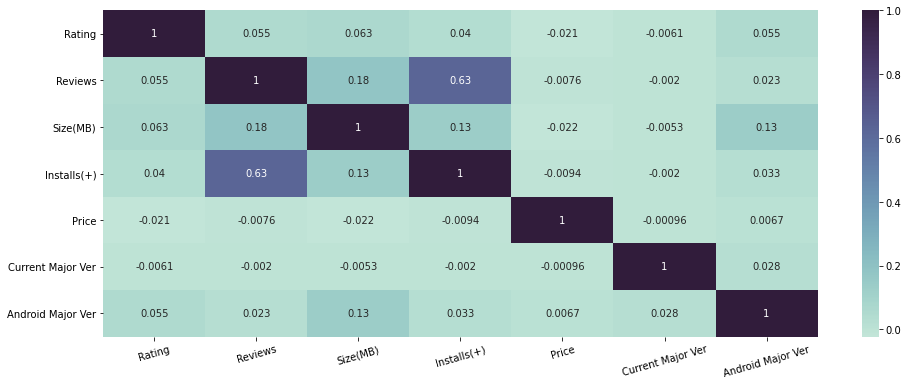

In [66]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True, cmap=cubehelix_palette)
plt.xticks(rotation=16)
plt.show()

**Pearson correlation coefficient significance**

![](https://miro.medium.com/max/466/1*Qz_gwy4ZaSZuOpl3IyO2HA.png)

Looking at above correlation plot, it can be seen that `Reviews` and `Installs(+)` have **moderate positive correlation**

### App

In [67]:
# Making changed on separate dataframe
apps_df = df[['App']].copy()
apps_df.head()

,App
0,Photo Editor & Candy Camera & Grid & ScrapBook
1,Coloring book moana
2,"U Launcher Lite – FREE Live Cool Themes, Hide ..."
3,Sketch - Draw & Paint
4,Pixel Draw - Number Art Coloring Book


In [68]:
# Using spacy to do text cleaning

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clean_app_name(name):
    name = nlp(' '.join(name.split()))
    clean_tokens = []
    for token in name:
        if token.is_digit: continue
        if not token.is_ascii: continue
        if token.is_stop: continue
        if token.is_punct: continue
        clean_tokens.append(token)
    return ' '.join([token.lemma_.lower() for token in clean_tokens])

apps_df['App'] = apps_df['App'].apply(clean_app_name)
apps_df.head()

,App
0,photo editor candy camera grid scrapbook
1,color book moana
2,u launcher lite free live cool themes hide apps
3,sketch draw paint
4,pixel draw number art coloring book


In [69]:
# Get word count dict
app_word_count = {}
for _, app_name in apps_df.App.iteritems():
    for word in app_name.split():
        if word in app_word_count.keys():
            app_word_count[word] += 1
        else:
            app_word_count[word] = 1

word_count = dict(Counter(app_word_count))
word_count_df = pd.DataFrame({
    'word': word_count.keys(),
    'count': word_count.values(),
})
word_count_df.sort_values(by='count', ascending=False).head(10)

,word,count
12,free,416
377,app,293
421,mobile,222
446,pro,196
126,video,181
13,live,157
1336,news,146
0,photo,145
132,game,136
516,chat,135


The most used word in app names is `free` followed by `app`, `game`, `mobile`, `video` and so on...

In [70]:
del word_count_df, app_word_count, word_count, apps_df

### Category

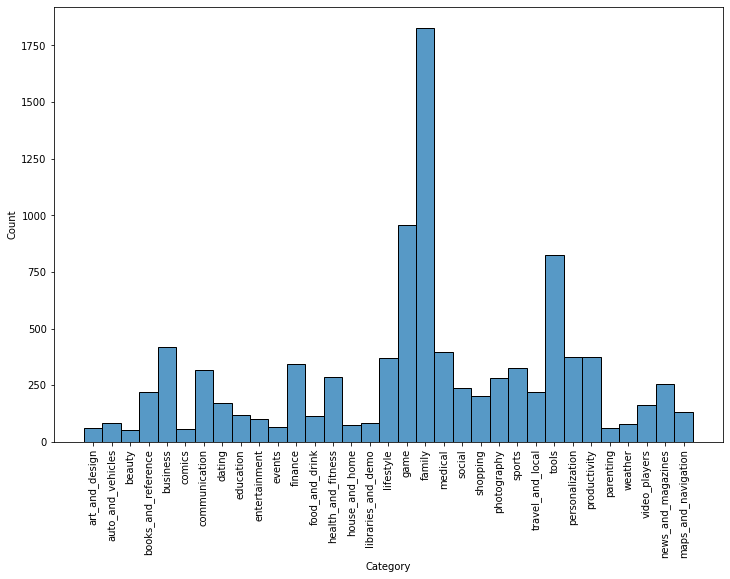

In [71]:
plt.figure(figsize=(12, 8))
sns.histplot(x=df['Category'])
plt.xticks(rotation=90)
plt.show()

Most of the apps fall in the category of `family`, then in `game` and `tools`.

**Relation between Category and Installs(+)**

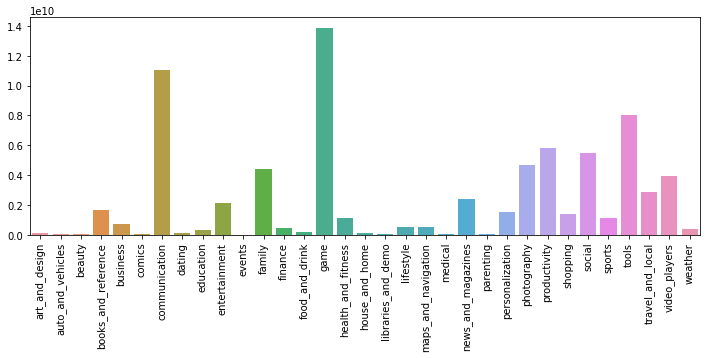

In [72]:
installs = []
categories = []
category_group = df.groupby(by='Category')

for category, category_df in category_group:
    categories.append(category)
    installs.append(category_df['Installs(+)'].sum())

plt.figure(figsize=(12, 4))
sns.barplot(x=categories, y=installs)
plt.xticks(rotation=90)
plt.show()

`game` category has most number of installs followd by `communication` and `tools`.

In [73]:
# Util funciton to make big numbers read easily
def format_num(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

Read number of installs per category more easily

In [74]:
installs_by_category = dict(Counter({key: value for key, value in zip(categories, installs)}))
installs_by_category_df = pd.DataFrame({
    'Category': installs_by_category.keys(),
    'Installs(+)': installs_by_category.values(),
    'Readable': [format_num(value) for value in installs_by_category.values()],
})
installs_by_category_df.sort_values(by='Installs(+)', ascending=False).head()

,Category,Installs(+),Readable
14,game,13878924415,13.9B
6,communication,11038276251,11B
29,tools,8001271905,8B
25,productivity,5793091369,5.79B
27,social,5487867902,5.49B


In [75]:
del installs, categories, category_group

**Relation btween Category and App Size**

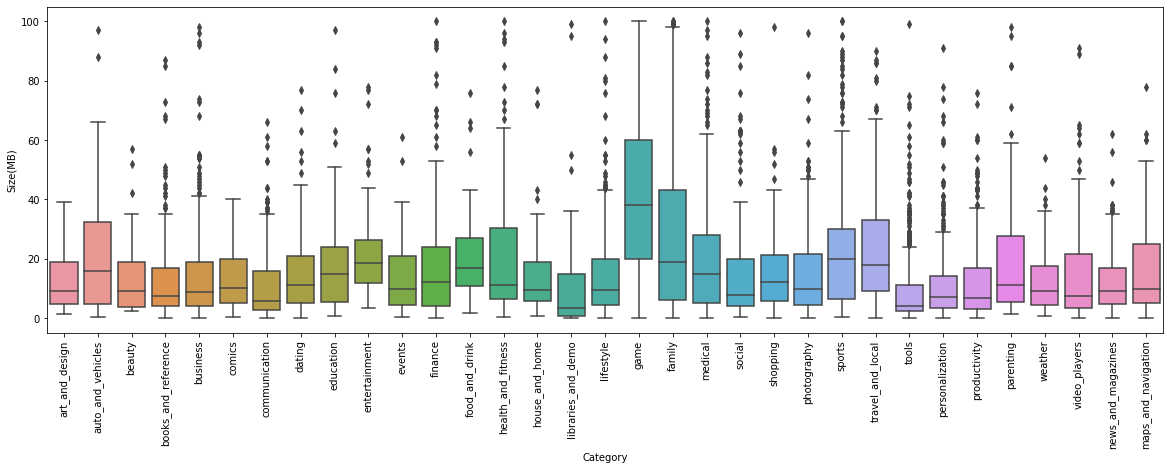

In [76]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='Size(MB)', data=df)
plt.xticks(rotation=90)
plt.show()

Categories such as `game`, `family`, `travel and local`, `health and fitness` and `auto and vehicles` have higher app sizes.

**Relation between Category and App Size with App Type**

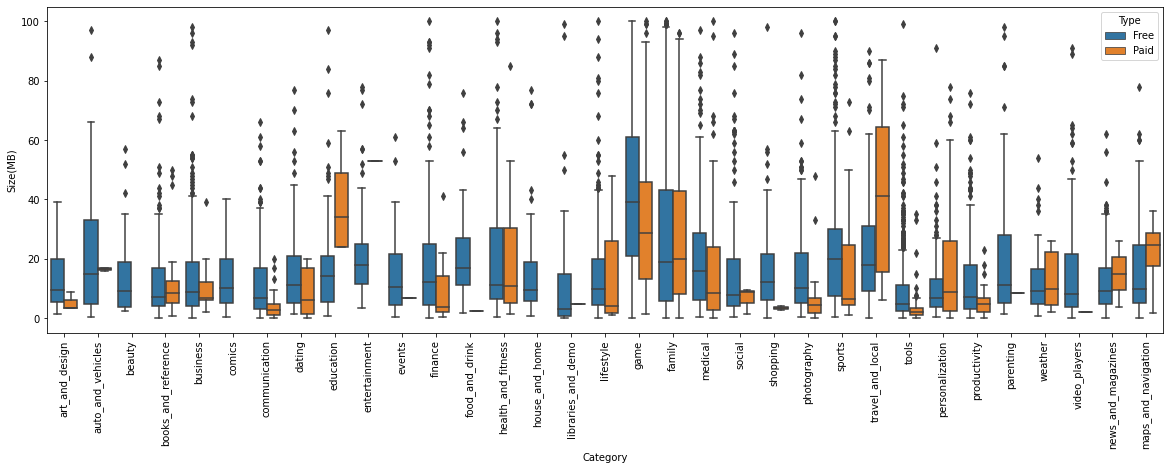

In [77]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='Size(MB)', data=df, hue='Type')
plt.xticks(rotation=90)
plt.show()

Categories like `game` (free & paid), `family` (free & paid), `travel and local` (paid), `health and fitness` (free and paid), `education` (paid) and `auto and vechicle` (free) have bigger app sizes.

**Relation between Category and Reviews**

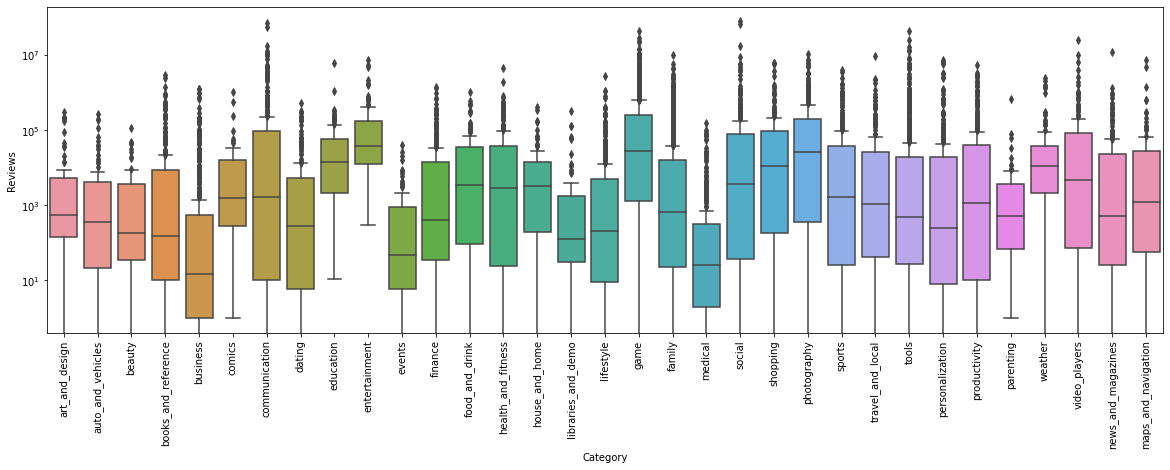

In [78]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='Reviews', data=df)
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

`game`, `entertainment`, `photography` categories have more reviews as compared to others.

**Relation between Category and Reviews with App Type**

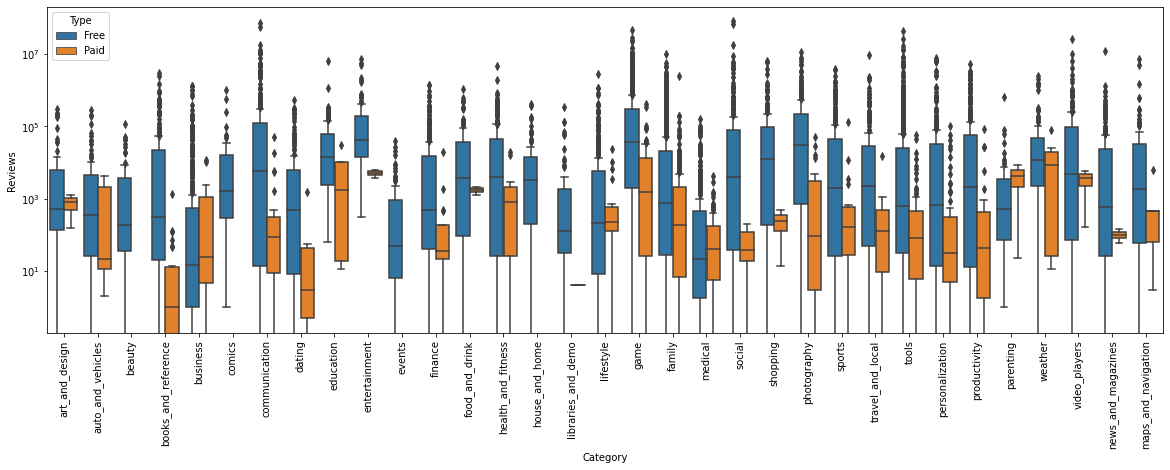

In [79]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='Reviews', data=df, hue='Type')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

`communication` (free), `game` (free > paid), `photography` (free > paid), `communication` (free) have more reviews compared to others.

**Relation between Category and Rating**

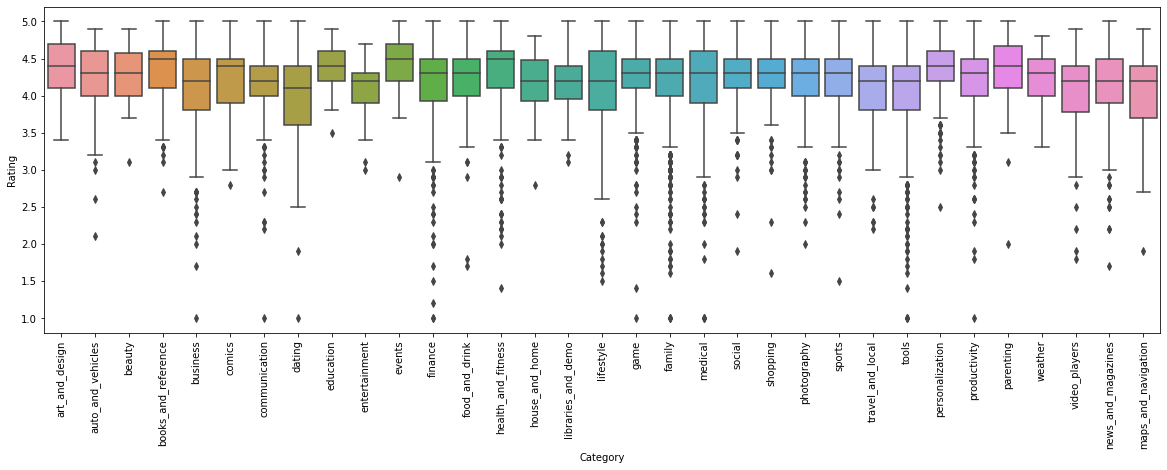

In [80]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='Rating', data=df)
plt.xticks(rotation=90)
plt.show()

Apps generally have higher ratings. There are very few apps having 1 star rating.

**Relation between Category and Rating with App Type**

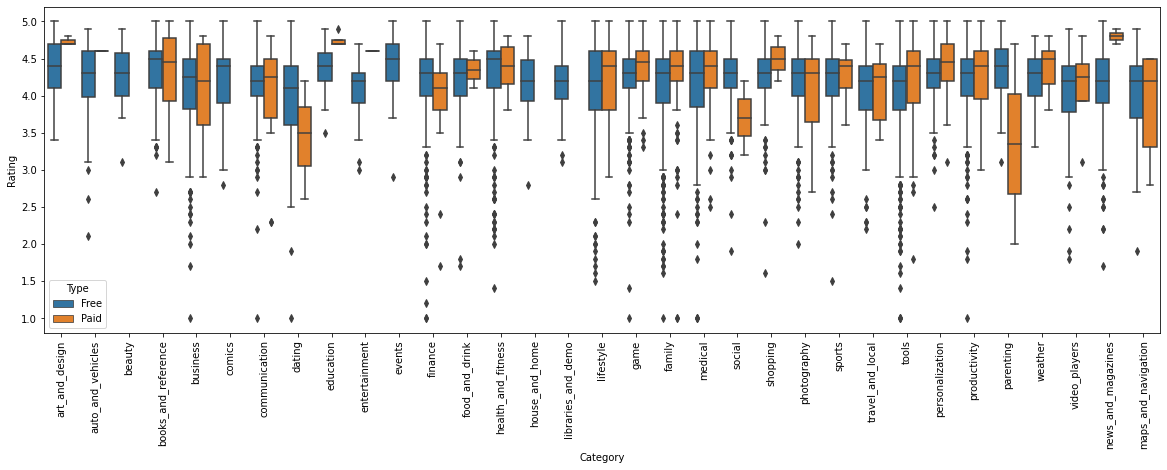

In [81]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='Rating', data=df, hue='Type')
plt.xticks(rotation=90)
plt.show()

For most of the categories, `Paid` app type has more ratings than the `Free` types.

Here `parenting` (paid) category has low ratings more than others.

In [82]:
df.loc[(df['Category'] == 'parenting') & (df['Type'] == 'Paid')]

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
4977,Baby Connect (activity log),parenting,4.7,8343,8.3,50000,Paid,4.99,Everyone,[Parenting],2018-07-10,6.3.16,4.0.3,6.0,4.0
6591,SharedCare™ Co-parenting,parenting,2.0,23,NaN,100,Paid,4.59,Everyone,[Parenting],2016-06-19,3.0.3,4.0,3.0,4.0


There're only 2 samples with category of `parenting`. So the above hypothesis doesn't holds good.

### Rating

In [83]:
df[['Rating']].head()

,Rating
0,4.1
1,3.9
2,4.7
3,4.5
4,4.3


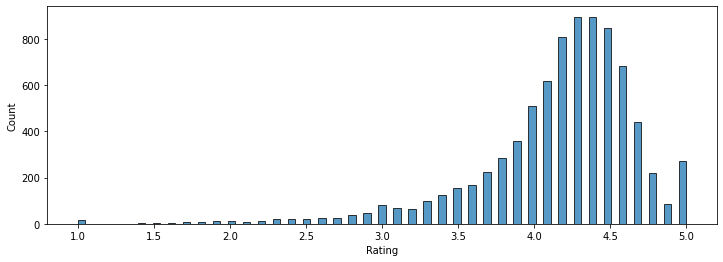

In [84]:
# Distribution
plt.figure(figsize=(12, 4))
sns.histplot(x=df['Rating'])
plt.show()

In [85]:
print(f'Mean: {df["Rating"].mean()}')
print(f'Median: {df["Rating"].median()}')
print(f'Mode: {df["Rating"].mode()[0]}')

Mean: 4.173321123321124
Median: 4.3
Mode: 4.3


Most of the ratings are `4.2 +/- something`. Also viewing the above plot we can see that there are some **outliers** too.

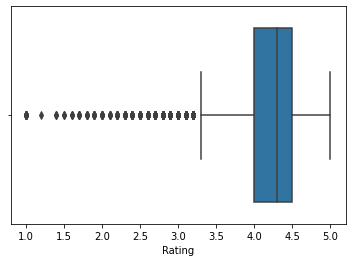

In [86]:
sns.boxplot(x=df['Rating'])
plt.show()

In [87]:
# Utils function
#
# Pearson correlation of a column with respect to others
def df_column_corr(df, column_name, how_many=None, ax=None):
    how_many = len(df) if how_many == None else how_many
    cor = df.corr()[[column_name]].sort_values(by=column_name, ascending=False)[:how_many]
    sns.heatmap(cor, annot=True, cmap=cubehelix_palette, ax=ax)
    plt.show()

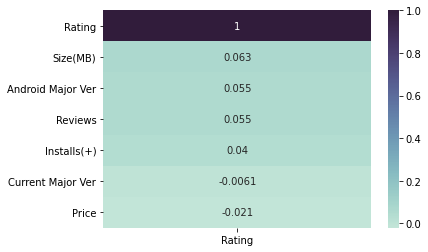

In [88]:
df_column_corr(df, 'Rating')

**Rating** column is not correlated with any other numerical column. If it's not even related to categorical columns then dropping the column would be better choice than dropping samples with missing ratings.

**Relating between Rating and Reviews**

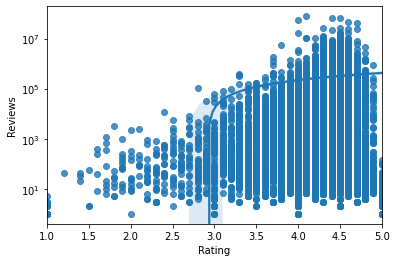

In [89]:
sns.regplot(x=df['Rating'], y=df['Reviews'])
plt.yscale('log')
plt.show()

Higher rated apps have more reviews, but the data set has more higher rated apps, so the results are baised.

In [90]:
df.loc[df['Rating'] >= 3][['Rating', 'Reviews']].corr()

,Rating,Reviews
Rating,1.000000,0.052821
Reviews,0.052821,1.000000


Apps rated above and equal to 3 have no correlation with reviews.

**Relation between Rating and App Size**

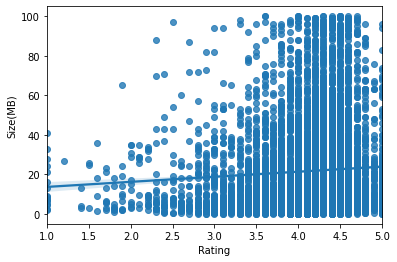

In [91]:
sns.regplot(x=df['Rating'], y=df['Size(MB)'])
plt.show()

Apps with higher ratings have more possible sizes compared to apps with lower ratings (<3.0), where the size is almost always under 40 MB.

**Apps which have got the least rating**

In [92]:
one_star_rating_apps = df.loc[df.Rating <= 1].copy()
print(f'There are {len(one_star_rating_apps)} apps with 1 star rating')

# Ordered by decreasing order of installs
one_star_rating_apps.sort_values(by='Installs(+)', ascending=False)

There are 16 apps with 1 star rating


,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
5307,BJ Bridge Standard American 2018,game,1.0,1,4.9,1000,Free,0.00,Everyone,[Card],2018-05-21,6.2-sayc,4.0,6.0,4.0
6857,Tech CU Card Manager,finance,1.0,2,7.2,1000,Free,0.00,Everyone,[Finance],2017-07-25,1.0.1,4.0,1.0,4.0
9143,FE Mechanical Engineering Prep,family,1.0,2,21.0,1000,Free,0.00,Everyone,[Education],2018-07-27,5.33.3669,5.0,5.0,5.0
6094,CB Mobile Biz,finance,1.0,3,8.4,500,Free,0.00,Everyone,[Finance],2016-02-22,4.4.1255,4.0,4.0,4.0
7694,DS Creator 2.0,tools,1.0,2,4.4,500,Free,0.00,Everyone,[Tools],2018-03-23,2.0.180226.1,4.0,2.0,4.0
9405,Lottery Ticket Checker - Florida Results & Lotto,tools,1.0,3,41.0,500,Free,0.00,Everyone,[Tools],2017-12-12,1.0,4.2,1.0,4.0
5474,MbH BM,medical,1.0,1,2.3,100,Free,0.00,Everyone,[Medical],2016-12-14,1.1.3,4.3,1.0,4.0
6329,Thistletown CI,productivity,1.0,1,6.6,100,Free,0.00,Everyone,[Productivity],2018-03-15,41.9,4.1,41.0,4.0
6372,CJ DVD Rentals,communication,1.0,5,13.0,100,Free,0.00,Everyone,[Communication],2017-10-06,1.0,4.1,1.0,4.0
6738,CR Magazine,business,1.0,1,7.8,100,Free,0.00,Everyone,[Business],2014-07-23,2.4.2,2.3.3,2.0,2.0


**5 apps with max ratings**

In [93]:
five_star_rating_apps = df.loc[df.Rating == 5].copy()
print(f'There are {len(five_star_rating_apps)} apps with 5 star rating')

# Ordered by decreasing order of installs
five_star_rating_apps.sort_values(by='Installs(+)', ascending=False).iloc[:5, :]

There are 271 apps with 5 star rating


,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
8375,Ek Bander Ne Kholi Dukan,family,5.0,10,3.0,10000,Free,0.0,Everyone,[Entertainment],2017-06-26,1.0.9,4.0,1.0,4.0
7175,"Superheroes, Marvel, DC, Comics, TV, Movies News",comics,5.0,34,12.0,5000,Free,0.0,Everyone,[Comics],2018-07-31,1.0.5,5.0,1.0,5.0
6456,CL Keyboard - Myanmar Keyboard (No Ads),tools,5.0,24,3.2,5000,Free,0.0,Everyone,[Tools],2018-06-13,1.1.3,4.3,1.0,4.0
6984,Oración CX,lifestyle,5.0,103,3.8,5000,Free,0.0,Everyone,[Lifestyle],2017-09-12,5.1.10,4.1,5.0,4.0
292,Hojiboy Tojiboyev Life Hacks,comics,5.0,15,37.0,1000,Free,0.0,Everyone,[Comics],2018-06-26,2.0,4.0.3,2.0,4.0


### Reviews

In [94]:
df[['Reviews']].head()

,Reviews
0,159
1,967
2,87510
3,215644
4,967


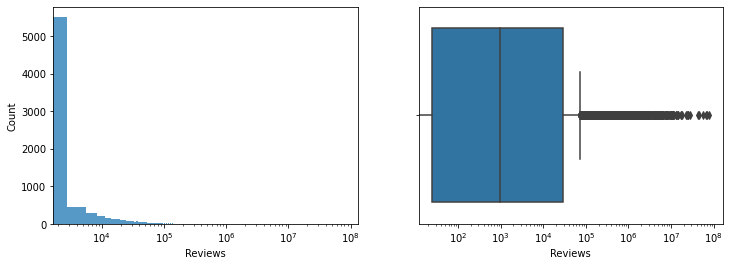

In [95]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(x=df['Reviews'], ax=ax[0])
sns.boxplot(x=df['Reviews'], ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
plt.show()

In [96]:
reviews = df['Reviews'].copy()

print(f'Mean: {format_num(reviews.mean())}')
print(f'Median: {reviews.median()}')
print(f'Mode: {reviews.mode()[0]}')
print(f'Max: {format_num(reviews.max())}')
print(f'Min: {reviews.min()}')
print(f'25%: {reviews.quantile(0.25)}')
print(f'50%: {reviews.quantile(0.50)}')
print(f'75%: {reviews.quantile(0.75)}')

del reviews

Mean: 217K
Median: 969.0
Mode: 0
Max: 78.2M
Min: 0
25%: 25.0
50%: 969.0
75%: 29449.25


In [97]:
print(len(df.loc[df['Reviews'] <= 217_000]))
print(len(df.loc[df['Reviews'] <= 29_000]))
print(len(df.loc[df['Reviews'] <= 9_000]))
print(len(df))

8669
7220
6310
9648


Most of the samples in the data set have number of reviews less than the average i.e. 217K and about which a large number of samples have number of reviews less 29K.

Removing **outliers** to see data more clearly.

In [98]:
# Helper functions for dealing with outliers

# Removing outliers using IQR method
def rm_outliers_in_col_using_iqr(df, col):
    # col here is df.column_name (or df[column_name])

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    outliers_row_idx = col.loc[
        (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))
    ].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Removing outliers using the Zscore method
def rm_outliers_in_col_using_zscore(df, col, column_name):
    # col here is df.column_name (or df[column_name])
    
    zscores_df = pd.DataFrame({
        f'{column_name}': col.to_numpy()
    }, df.index.tolist())
    
    zscores_df['zscores'] = zscores_df.apply(lambda x: zscore(x))
    outliers_row_idx = zscores_df[np.abs(zscores_df.zscores) > 3].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Remove outliers of a column using iqr & zscore methods
def remove_outliers_of_a_column(df, column_name):
    rm_idxs = []
    for _ in range(10):
        outliers_row_idx, df = rm_outliers_in_col_using_iqr(df, df[column_name])
        rm_idxs.extend(outliers_row_idx)
        
        outliers_row_idx, df = rm_outliers_in_col_using_zscore(df, df[column_name], column_name)
        rm_idxs.extend(outliers_row_idx)
    return rm_idxs, df


# Remove outliers of a df using iqr & zscore methods
def remove_outliers_of_df(df, dont_drop_columns=[]):
    rm_rows_idxs = []
    for column in df.columns.tolist():
        if column in dont_drop_columns:
            # Don't drop this column
            continue
            
        rm_idxs, df = remove_outliers_of_a_column(df, column)
        rm_rows_idxs.extend(rm_idxs)
    return rm_rows_idxs, df

In [99]:
reviews_df = df[['Reviews']].copy()
size_before = len(reviews_df)
print(f'Data set before removing outliers: {size_before}')

dropped_idxs, reviews_df = rm_outliers_in_col_using_iqr(reviews_df, df['Reviews'])

size_after = len(reviews_df)
print(f'Data set after removing outliers: {size_after}')
print(f'Number of samples dropped: {len(dropped_idxs)} i.e. {round(len(dropped_idxs) / size_before * 100, 2)}% of the data set')

Data set before removing outliers: 9648
Data set after removing outliers: 7993
Number of samples dropped: 1655 i.e. 17.15% of the data set


In [100]:
reviews_df = df[['Reviews']].copy()
size_before = len(reviews_df)
print(f'Data set before removing outliers: {size_before}')

dropped_idxs, reviews_df = rm_outliers_in_col_using_zscore(reviews_df, df['Reviews'], 'Reviews')

size_after = len(reviews_df)
print(f'Data set after removing outliers: {size_after}')
print(f'Number of samples dropped: {len(dropped_idxs)} i.e. {round(len(dropped_idxs) / size_before * 100, 2)}% of the data set')

Data set before removing outliers: 9648
Data set after removing outliers: 9580
Number of samples dropped: 68 i.e. 0.7% of the data set


In [101]:
reviews_df = df[['Reviews']].copy()
size_before = len(reviews_df)
print(f'Data set before removing outliers: {size_before}')

dropped_idxs, reviews_df = remove_outliers_of_a_column(reviews_df, 'Reviews')

size_after = len(reviews_df)
print(f'Data set after removing outliers: {size_after}')
print(f'Number of samples dropped: {len(dropped_idxs)} i.e. {round(len(dropped_idxs) / size_before * 100, 2)}% of the data set')

Data set before removing outliers: 9648
Data set after removing outliers: 2659
Number of samples dropped: 6989 i.e. 72.44% of the data set


Using the **IQR** and **Z Score** methods remove 17% and 0.7% samples from the data set respectively.

Using `remove_outliers_of_a_column` removes 72% of the samples from the data set because it iterates 10x to remove outliers (not using this one for `Reviews`).

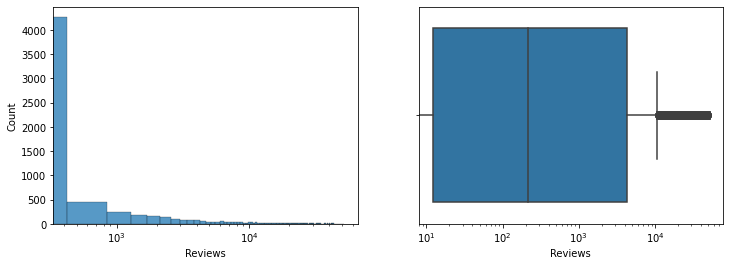

In [102]:
reviews_df = df[['Reviews']].copy()
_, reviews_df = rm_outliers_in_col_using_iqr(reviews_df, reviews_df['Reviews'])
_, reviews_df = rm_outliers_in_col_using_zscore(reviews_df, reviews_df['Reviews'], 'Reviews')

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(x=reviews_df['Reviews'], ax=ax[0])
sns.boxplot(x=reviews_df['Reviews'], ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
plt.show()

del reviews_df

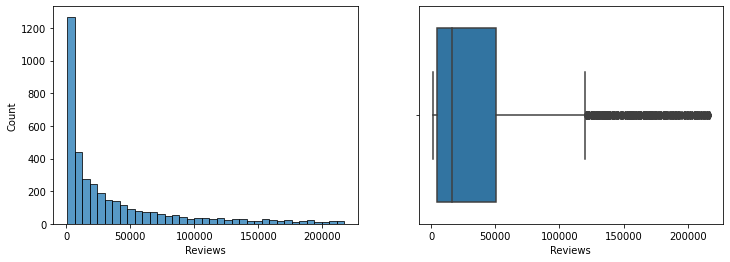

In [103]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(x=df.loc[(df['Reviews'] <= 217_000) & (df['Reviews'] > 1_000)]['Reviews'], ax=ax[0])
sns.boxplot(x=df.loc[(df['Reviews'] <= 217_000) & (df['Reviews'] > 1_000)]['Reviews'], ax=ax[1])
plt.show()

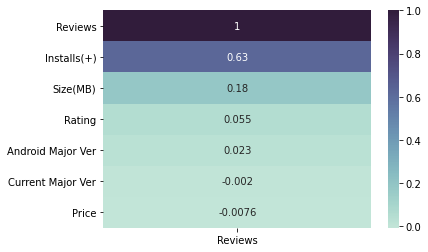

In [104]:
df_column_corr(df, 'Reviews')

`Reviews` has positive moderate correlation with `Installs(+)`

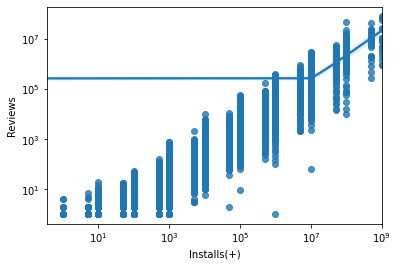

In [105]:
sns.regplot(x=df['Installs(+)'], y=df['Reviews'])
plt.xscale('log')
plt.yscale('log')
plt.show()

Apps with more installs tends to have more reviews.

**5 apps with most reviews**

In [106]:
df.sort_values(by='Reviews', ascending=False).head()

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
2000,Facebook,social,4.1,78158306,NaN,1000000000,Free,0.0,Teen,[Social],2018-08-03,NaN,NaN,NaN,NaN
299,WhatsApp Messenger,communication,4.4,69119316,NaN,1000000000,Free,0.0,Everyone,[Communication],2018-08-03,NaN,NaN,NaN,NaN
2001,Instagram,social,4.5,66577313,NaN,1000000000,Free,0.0,Teen,[Social],2018-07-31,NaN,NaN,NaN,NaN
298,Messenger – Text and Video Chat for Free,communication,4.0,56642847,NaN,1000000000,Free,0.0,Everyone,[Communication],2018-08-01,NaN,NaN,NaN,NaN
1370,Clash of Clans,game,4.6,44891723,98.0,100000000,Free,0.0,Everyone 10+,[Strategy],2018-07-15,10.322.16,4.1,10.0,4.0


### Size

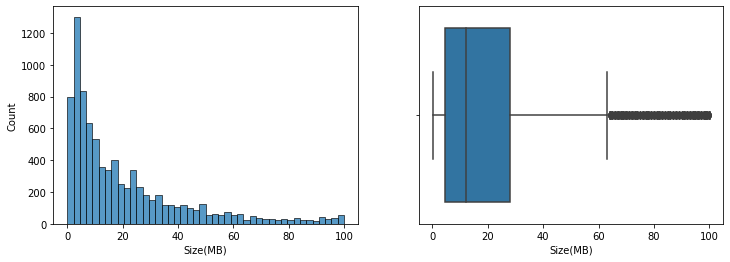

In [107]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(x=df['Size(MB)'], ax=ax[0])
sns.boxplot(x=df['Size(MB)'], ax=ax[1])
plt.show()

The distribution of app size is a right skewed long tail.

In [108]:
print(df['Size(MB)'].mean())
print(df['Size(MB)'].median())
print(df['Size(MB)'].mode()[0])
print(df['Size(MB)'].min())
print(df['Size(MB)'].max())

20.41394579672287
12.0
11.0
0.0085
100.0


Most of the apps have size lower than 20, and some apps have sizes around 100MB.

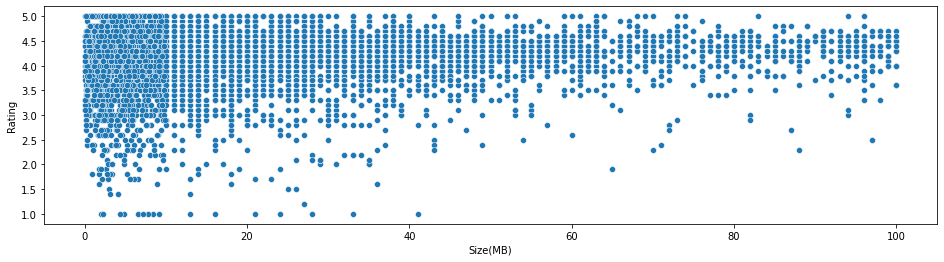

In [109]:
_, ax = plt.subplots(figsize=(16, 4))
sns.scatterplot(x='Size(MB)', y='Rating', data=df, ax=ax)
plt.show()

Apps with bigger size tends to have higher rating while apps with lower size have rating spread out mostly betweeen 3 and 5.

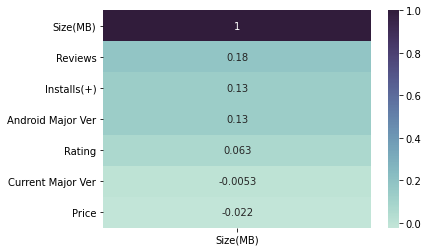

In [110]:
df_column_corr(df, 'Size(MB)')

`Size(MB)` columns is not correlated to any other column

**5 apps with largest app sizes**

In [111]:
df.sort_values(by='Size(MB)', ascending=False).head()

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
4874,Gangster Town: Vice District,family,4.3,65146,100.0,10000000,Free,0.0,Mature 17+,[Simulation],2018-05-31,2.1,4.0,2.0,4.0
7315,Car Crash III Beam DH Real Damage Simulator 2018,game,3.6,151,100.0,10000,Free,0.0,Everyone,[Racing],2018-05-20,1.03,4.1,1.0,4.0
7721,Draft Simulator for FUT 18,sports,4.6,162933,100.0,5000000,Free,0.0,Everyone,[Sports],2018-05-11,25.7,4.1,25.0,4.0
4559,The Walking Dead: Our World,game,4.0,22435,100.0,1000000,Free,0.0,Teen,[Action],2018-08-01,1.1.0.3,5.0,1.0,5.0
1275,Talking Babsy Baby: Baby Games,lifestyle,4.0,140995,100.0,10000000,Free,0.0,Everyone,"[Pretend Play, Lifestyle]",2018-07-16,9.0,4.0,9.0,4.0


**5 apps with smallest app sizes**

In [112]:
df.sort_values(by='Size(MB)').head()

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
1243,Essential Resources,libraries_and_demo,4.6,237,0.0085,50000,Free,0.00,Everyone,[Libraries & Demo],2017-09-27,1.02,7.1,1.0,7.0
4035,My baby firework (Remove ad),family,4.1,30,0.0140,1000,Paid,0.99,Everyone,[Entertainment],2013-04-25,NaN,NaN,NaN,NaN
8902,ExDialer PRO Key,communication,4.5,5474,0.0170,100000,Paid,3.99,Everyone,[Communication],2014-01-15,81,2.1,8.0,2.0
4030,Ad Remove Plugin for App2SD,productivity,4.1,66,0.0170,1000,Paid,1.29,Everyone,[Productivity],2013-09-25,1.0.0,2.2,1.0,2.0
408,"Private Dating, Hide App- Blue for PrivacyHider",dating,NaN,0,0.0180,100,Paid,2.99,Everyone,[Dating],2017-07-25,1.0.1,4.0,1.0,4.0


### Installs

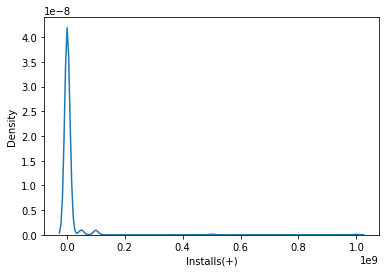

In [113]:
sns.kdeplot(x=df['Installs(+)'])
plt.show()

Most of the apps installs are relative small compared to the maximum, which is around 1e9 (a billion).

**10 apps with most installs**

In [114]:
df.sort_values(by='Installs(+)', ascending=False).head(10)

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
2975,Google News,news_and_magazines,3.9,877635,13.0,1000000000,Free,0.0,Teen,[News & Magazines],2018-08-01,5.2.0,4.4,5.0,4.0
2418,Maps - Navigate & Explore,travel_and_local,4.3,9235155,NaN,1000000000,Free,0.0,Everyone,[Travel & Local],2018-07-31,NaN,NaN,NaN,NaN
2427,Google Street View,travel_and_local,4.2,2129689,NaN,1000000000,Free,0.0,Everyone,[Travel & Local],2018-08-06,NaN,NaN,NaN,NaN
2906,YouTube,video_players,4.3,25655305,NaN,1000000000,Free,0.0,Teen,[Video Players & Editors],2018-08-02,NaN,NaN,NaN,NaN
2928,Google Play Movies & TV,video_players,3.7,906384,NaN,1000000000,Free,0.0,Teen,[Video Players & Editors],2018-08-06,NaN,NaN,NaN,NaN
2010,Google+,social,4.2,4831125,NaN,1000000000,Free,0.0,Teen,[Social],2018-07-26,NaN,NaN,NaN,NaN
2001,Instagram,social,4.5,66577313,NaN,1000000000,Free,0.0,Teen,[Social],2018-07-31,NaN,NaN,NaN,NaN
2000,Facebook,social,4.1,78158306,NaN,1000000000,Free,0.0,Teen,[Social],2018-08-03,NaN,NaN,NaN,NaN
2505,Google,tools,4.4,8033493,NaN,1000000000,Free,0.0,Everyone,[Tools],2018-08-03,NaN,NaN,NaN,NaN
151,Google Play Books,books_and_reference,3.9,1433233,NaN,1000000000,Free,0.0,Teen,[Books & Reference],2018-08-03,NaN,NaN,NaN,NaN


**5 apps with least installs**

In [115]:
df.sort_values(by='Installs(+)').head()

,App,Category,Rating,Reviews,Size(MB),Installs(+),Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Current Major Ver,Android Major Ver
4952,Ain Arabic Kids Alif Ba ta,family,NaN,0,33.0,0,Paid,2.99,Everyone,[Education],2016-04-15,1.0,3.0,1.0,3.0
8567,EP Cook Book,medical,NaN,0,3.2,0,Paid,200.00,Everyone,[Medical],2015-07-26,1.0,3.0,1.0,3.0
7007,CX Network,business,NaN,0,10.0,0,Free,0.00,Everyone,[Business],2018-08-06,1.3.1,4.1,1.0,4.0
5656,cronometra-br,productivity,NaN,0,5.4,0,Paid,154.99,Everyone,[Productivity],2017-11-24,1.0.0,4.1,1.0,4.0
8770,I'm Rich/Eu sou Rico/أنا غني/我很有錢,lifestyle,NaN,0,40.0,0,Paid,399.99,Everyone,[Lifestyle],2017-12-01,MONEY,4.1,NaN,4.0


**Apps having 0 installs**

In [116]:
len(df.loc[df['Installs(+)'] == 0])

14

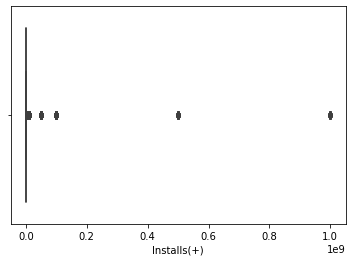

In [117]:
sns.boxplot(x=df['Installs(+)'])
plt.show()

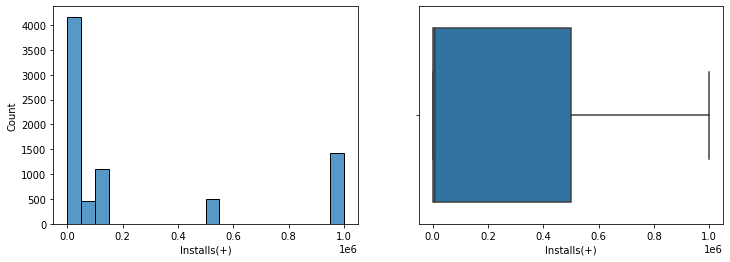

In [118]:
# Remove outliers

installs_df = df[['Installs(+)']].copy()
_, installs_df = rm_outliers_in_col_using_iqr(installs_df, installs_df['Installs(+)'])
_, installs_df = rm_outliers_in_col_using_zscore(installs_df, installs_df['Installs(+)'], 'Installs(+)')

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(x=installs_df['Installs(+)'], ax=ax[0])
sns.boxplot(x=installs_df['Installs(+)'], ax=ax[1])
plt.show()

In [119]:
print(len(installs_df))
print(len(installs_df.loc[installs_df['Installs(+)'] <= 200_000]))

7670
5750


Most apps have installs less than 200K (after removing outliers).

In [120]:
del installs_df

### Types & Price

92.2% of apps in the data set are Free


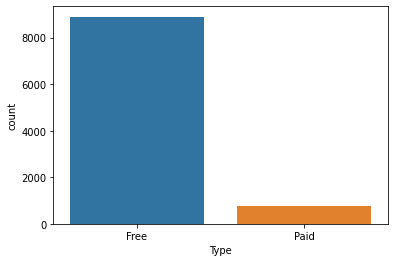

In [121]:
type_count = round(len(df.loc[df['Type'] == 'Free']))
print(f'{round(type_count / len(df) * 100, 2)}% of apps in the data set are Free')
sns.countplot(x=df['Type'])
plt.show()

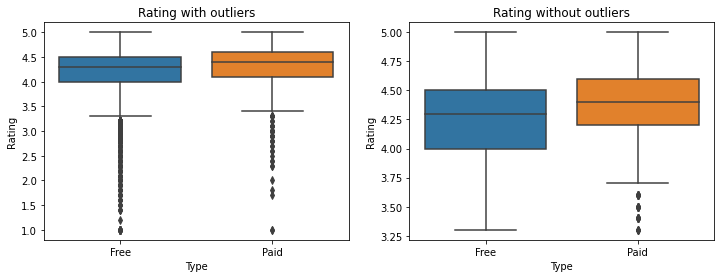

In [122]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Data set with outliers in `Rating`
sns.boxplot(x=df['Type'], y=df['Rating'], ax=ax[0])
ax[0].set_title('Rating with outliers')

# Data set without outliers
rating_df = df[['Rating', 'Type']].copy()
_, rating_df = rm_outliers_in_col_using_iqr(rating_df, df['Rating'])
_, rating_df = rm_outliers_in_col_using_zscore(rating_df, rating_df['Rating'], 'Rating')
sns.boxplot(x=rating_df['Type'], y=rating_df['Rating'], ax=ax[1])
ax[1].set_title('Rating without outliers')

del rating_df

plt.show()

After removing outliers, the paid apps have more ratings than free apps.

In [123]:
paid_df = pd.DataFrame({
    'category': [],
    'count': [],
    'total_price': [],
    'installs(+)': [],
    'mean_price': [],
    'avg_rating': [],
    'content_rating': [],
})

for category_name, category_df in df[df.Type == 'Paid'].groupby(by='Category'):
    paid_df = paid_df.append({
        'category': category_name, 
        'count': len(category_df), 
        'total_price': category_df['Price'].sum(),
        'installs(+)': format_num(category_df['Installs(+)'].sum()),
        'mean_price': f'${round(category_df["Price"].mean(), 2)}',
        'avg_rating': round(category_df['Rating'].mean(), 2),
        'content_rating': list(set([cr for cr in category_df['Content Rating']]))
    }, ignore_index=True)

paid_df.head()

,category,count,total_price,installs(+),mean_price,avg_rating,content_rating
0,art_and_design,3.0,5.97,16K,$1.99,4.73,[Everyone]
1,auto_and_vehicles,3.0,13.47,50.2K,$4.49,4.60,[Everyone]
2,books_and_reference,28.0,119.77,23.3K,$4.28,4.28,"[Everyone, Teen]"
3,business,12.0,175.29,213K,$14.61,4.08,[Everyone]
4,communication,27.0,83.14,1.36M,$3.08,4.06,"[Mature 17+, Everyone]"


**Category with highest total price**

In [124]:
paid_df.loc[paid_df['total_price'] == paid_df['total_price'].max()]

,category,count,total_price,installs(+),mean_price,avg_rating,content_rating
10,finance,17.0,2900.83,186K,$170.64,3.83,"[Everyone, Teen]"


**Category with most paid apps**

In [125]:
paid_df.loc[paid_df['count'] == paid_df['count'].max()]

,category,count,total_price,installs(+),mean_price,avg_rating,content_rating
9,family,182.0,2398.87,20.6M,$13.18,4.29,"[Everyone 10+, Mature 17+, Everyone, Teen]"


`family` category earns a lot of money. At the same time the `average price` of paid `finance` category app is almost **13x** of a `family` category app.

### Content Rating

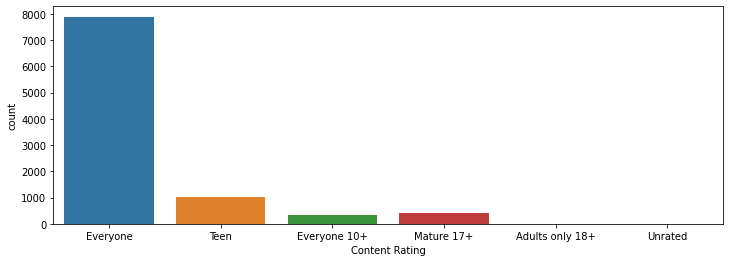

In [126]:
plt.figure(figsize=(12, 4))
sns.countplot(x=df['Content Rating'])
plt.show()

Most apps are for `everyone`

**Relation between Content Rating and Rating**

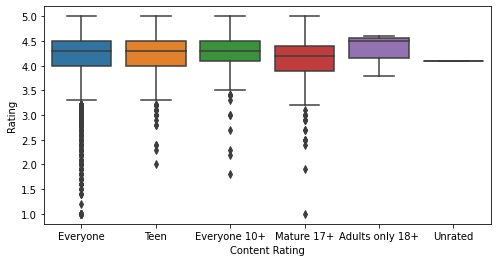

In [127]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Content Rating'], y=df['Rating'])
plt.show()

`Adults only 18+` apps are more dense around 4-4.5 rating, whereas other apps have a higher variance, outliers and have at least some apps with rating=5.

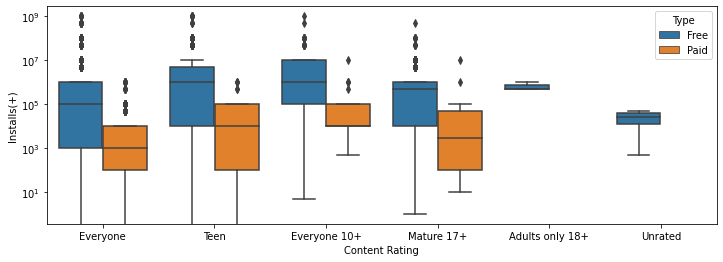

In [128]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='Content Rating', y='Installs(+)', hue='Type', data=df)
plt.yscale('log')
plt.show()

`Free` apps have more installs compared to paid apps and that apps for Everyone10+ have more installs.

### Genres

In [129]:
# Get unique genres from Genres column
def unique_genres(genres_series):
    unique = set()
    for genres in genres_series:
        for genre in genres:
            if genre not in unique:
                unique.add(genre)
    return unique

# Create label encoding for `Genres` column in our data set
def label_encode_genres(df):
    columns = ['App']
    columns.extend(list(unique_genres(df['Genres'])))
    genres_df = pd.DataFrame(columns=columns)

    for _, row in df.iterrows():
        entry = {column_name: 0 for column_name in genres_df.columns}
        entry['App'] = row['App']
        for genre in row['Genres']:
            entry[genre] = 1
        genres_df = genres_df.append(entry, ignore_index=True)
    return genres_df


genres_df = label_encode_genres(df)
genres_df.head()

,App,Libraries & Demo,Brain Games,Travel & Local,Medical,House & Home,Adventure,Weather,Photography,Education,...,Word,Racing,Sports,Music,Parenting,Casual,Music & Video,Books & Reference,Music & Audio,Comics
0,Photo Editor & Candy Camera & Grid & ScrapBook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are 53 unique genres


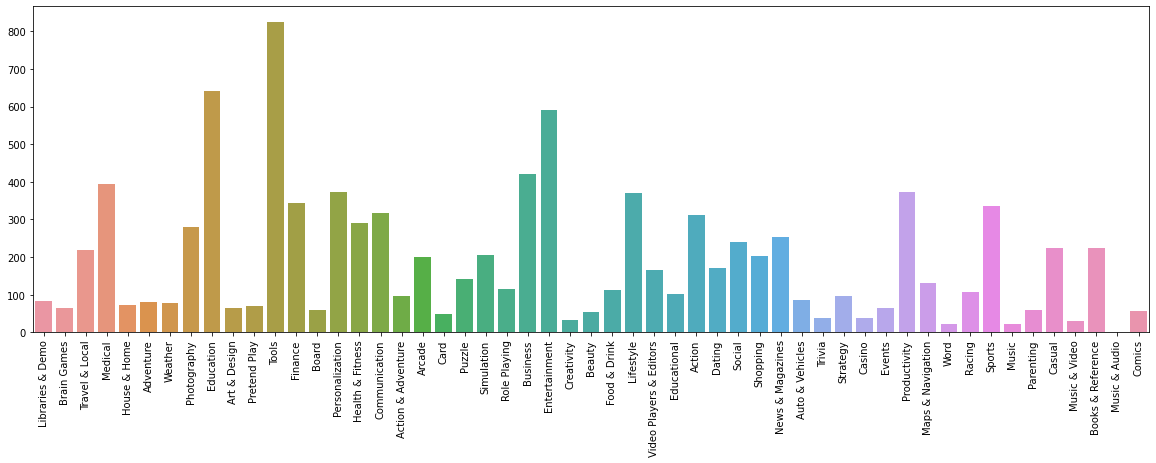

In [130]:
genres_info = {}
for column_name in [column for column in genres_df.columns if column != 'App']:
    genres_info[column_name] = genres_df[column_name].sum()

print(f'There are {len(genres_info)} unique genres')

plt.figure(figsize=(20, 6))
sns.barplot(x=list(genres_info.keys()), y=list(genres_info.values()))
plt.xticks(rotation=90)
plt.show()

Most of the apps fall in `tools` genre followed by `eduction` and `entertainment` which is quite different from `app category` where most apps fall are `family`, then in `game` and `tools`.

### Last Updated

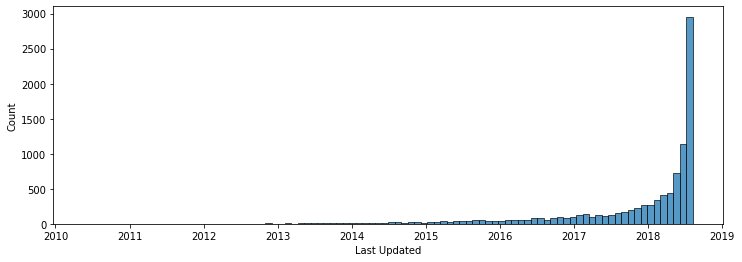

In [131]:
plt.figure(figsize=(12, 4))
sns.histplot(x=df['Last Updated'])
plt.show()

Most apps have been recently updated recently (w.r.t. dataset publication). There are also apps that have been last updated before 2014.

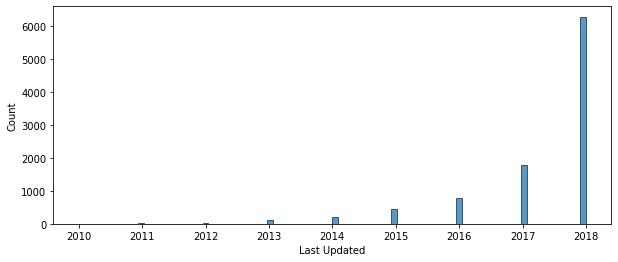

In [132]:
plt.figure(figsize=(10, 4))
sns.histplot(x=df['Last Updated'].dt.year)
plt.show()

Large number of apps have been updated by 2018.

### Current Ver

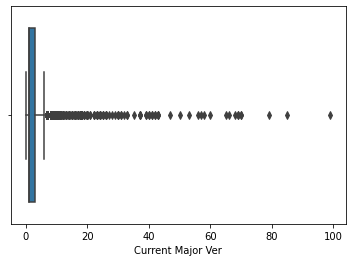

In [133]:
sns.boxplot(x=df.loc[df['Current Major Ver'] < 100]['Current Major Ver'])
plt.show()

We can see that by considering only apps with a version number lower than 100, we already have lots of outliers.

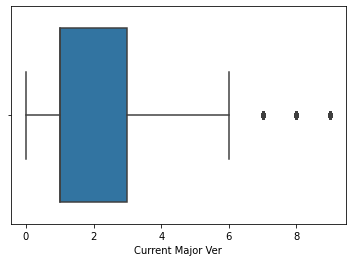

In [134]:
sns.boxplot(x=df.loc[df['Current Major Ver'] < 10]['Current Major Ver'])
plt.show()

By considering only apps with version lower than 10 we can start understanding the version feature distribution

In [135]:
print('Total apps', len(df))
print('Number of apps with current version lower than 1000:', len(df.loc[df['Current Major Ver'] < 1000]))
print('Number of apps with current version lower than 100:', len(df.loc[df['Current Major Ver'] < 100]))
print('Number of apps with current version lower than 10:', len(df.loc[df['Current Major Ver'] < 10]))
print('Number of apps with current version lower than 6:', len(df.loc[df['Current Major Ver'] < 6]))

Total apps 9648
Number of apps with current version lower than 1000: 8312
Number of apps with current version lower than 100: 8304
Number of apps with current version lower than 10: 8030
Number of apps with current version lower than 6: 7485


According to the boxplot, we could consider apps with a version higher than 6 as outliers. For modeling this outliers can be removed.

### Android Ver

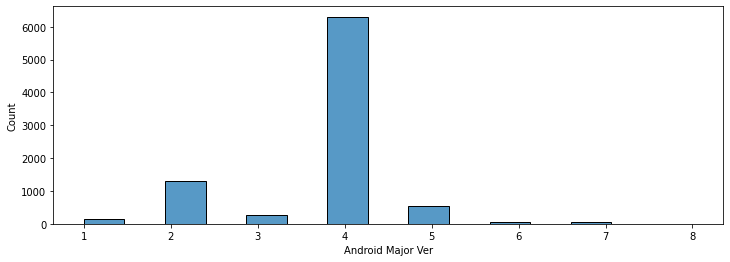

In [136]:
plt.figure(figsize=(12, 4))
sns.histplot(x=df['Android Major Ver'])
plt.show()

Most apps are for android version 4.

All of the columns are `iterated` and **analyzed**.